In [1]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ad_toolkit.evaluation import Result, TimeSeriesPlot

### Load training data and labels

In [2]:
result_dir = pathlib.Path('../results/esa_anom_and_sc')

In [3]:
START, END = '2019-09-20', '2019-10-01'
data_dir = pathlib.Path('../results/esa')
train_data = pd.read_csv(data_dir / "train_data.csv", parse_dates=True, index_col="date")
label_data = pd.read_csv(data_dir / "labels.csv", index_col='index')
ranges = []

for _, row in label_data.iterrows():
    ranges.append((row['Start-Time'], row['End-Time']))
labels = pd.Series(np.zeros((len(train_data, ))), index=train_data.index)
for start, end in ranges:
    labels[start:end] = 1
    
labels = labels[START:END]

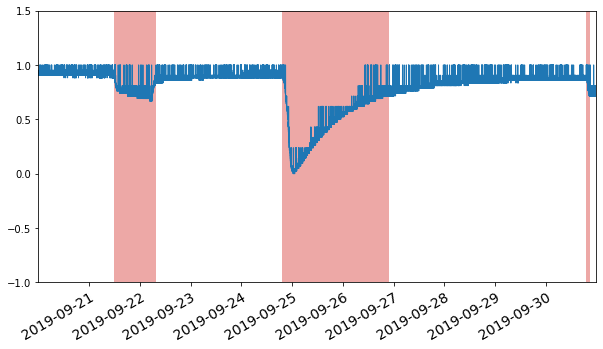

In [5]:
fig, ax = TimeSeriesPlot.plot(train_data['NEI00055'], labels=labels)
ax.set_ylim((-1, 1.5))
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=14)
plt.show()

### Analyze anomalies reported by all models

In [58]:

all_data = {}
all_files = {
    'ae': ('ae_esa_anom.pkl', 'ae_esa_raw.pkl'),
    'vae': ('vae_esa_anom.pkl', 'vae_esa_raw.pkl'),
    'lstm_ad': ('lstm_ad_esa_anom.pkl', 'lstm_ad_esa_raw.pkl'),
}

# left-most anomaly window
# s = "2019-09-21 12:15:00"
# e = "2019-09-22 07:15:00"
# middle anomaly window
s = "2019-09-24 19:31:03"
e = "2019-09-26 21:19:59"
# right-most anomaly window
# s = "2019-09-30 19:30:00"
# e = "2019-09-30 20:30:00"

all_anomalies = {}
for detector, (anom_file, raw_file) in all_files.items():
    anomalies = pickle.load((result_dir / anom_file).open("rb"))
    raw_scores = pickle.load((result_dir / raw_file).open("rb"))
    
    a = pd.Series(anomalies, index=labels.index)
    mask = (a.index > s) & (a.index < e) & (a == 1)
    mean_scores = np.abs(raw_scores[mask]).mean(0)
    
    all_data[detector] = (mean_scores / np.sum(mean_scores))
    all_anomalies[detector.upper()] = anomalies

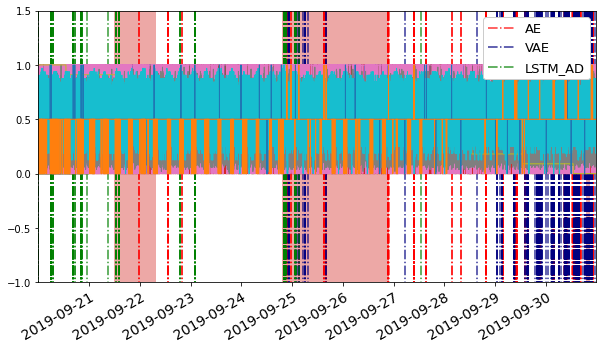

In [59]:
anomaly_style_kwargs = {'alpha': 0.8, 'lw': 1.5}
legend_style_kwargs = {'framealpha': 1, 'fontsize': 13, 'loc': 1}
fig, ax = TimeSeriesPlot.plot(train_data, labels=labels, 
                              anomalies=all_anomalies, show_legend=True,
                              anomaly_style_kwargs = anomaly_style_kwargs,
                              legend_style_kwargs = legend_style_kwargs)
ax.set_ylim((-1, 1.5))
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=14)
# plt.xticklabels()
plt.show()

### Analyze average error made per parameter by models in the middle time window 

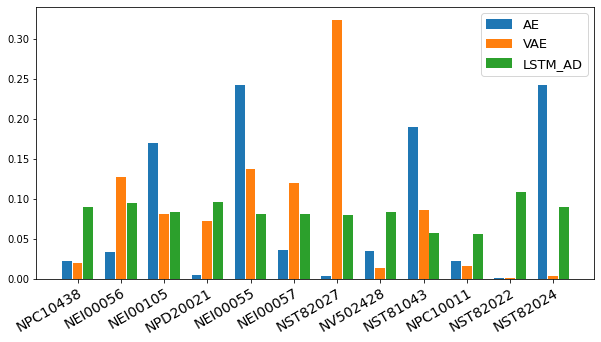

In [13]:
x = np.arange(len(train_data.columns))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, all_data['ae'], width/2.2, label='AE')
rects2 = ax.bar(x, all_data['vae'], width/2.2, label='VAE')
rects3 = ax.bar(x + width/2, all_data['lstm_ad'], width/2.2, label='LSTM_AD')

ax.set_xticks(x)
ax.set_xticklabels(train_data.columns)
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=14)
plt.legend(fontsize=13)
fig.set_size_inches((10, 5))
plt.show()

### Check Donut results

In [10]:
def n_largest(arr, n=60):
    return np.argpartition(arr, -n)[-n:]

In [4]:
donut_scores = {}
for file in result_dir.glob('donut_*'):
    param = file.name.lstrip('donut_').rstrip('.pkl')
    scores = pickle.load((file).open('rb'))
    
    donut_scores[param] = scores

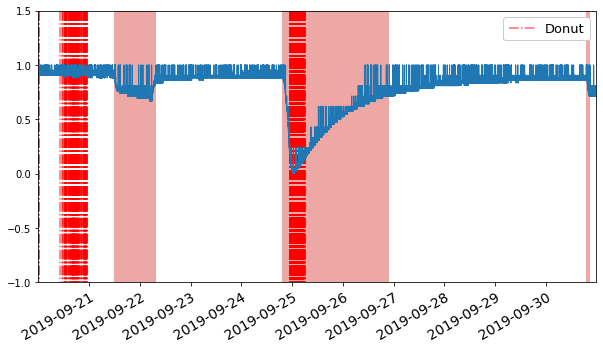

In [28]:
s = donut_scores['NEI00055_good']

anomalies = np.zeros((len(labels),))
idx = n_largest(s, n=2000)
anomalies[idx] = 1

anomaly_style_kwargs = {'alpha': 0.6, 'lw': 1.5}
fig, ax = TimeSeriesPlot.plot(train_data['NEI00055'], labels=labels,
                              anomalies={'Donut': anomalies}, show_legend=True, 
                              anomaly_style_kwargs=anomaly_style_kwargs, 
                              legend_style_kwargs={'framealpha': 1, 'fontsize': 13})
ax.set_ylim((-1, 1.5))
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=14)
plt.show()

## Check AE results per parameter

In [29]:
ae_result_dir = pathlib.Path('../ae_per_param')
ae_scores = {}
for file in ae_result_dir.glob('ae*'):
    param = file.name.lstrip('ae_').rstrip('.pkl')
    scores = pickle.load((file).open('rb'))
    
    ae_scores[param] = scores

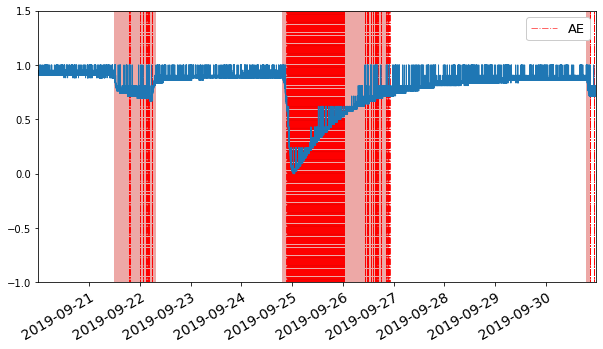

In [32]:
s = ae_scores['NEI00055']
anomalies = (s > np.mean(s) * 5)

anomaly_style_kwargs = {'alpha': 0.6, 'lw': 1}
fig, ax = TimeSeriesPlot.plot(train_data['NEI00055'], labels=labels,
                              anomalies={'AE': anomalies}, show_legend=True, 
                              anomaly_style_kwargs=anomaly_style_kwargs, 
                              legend_style_kwargs={'framealpha': 1, 'fontsize': 13})
ax.set_ylim((-1, 1.5))
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=14)
plt.show()